In [ ]:
# @title Install VGGT model and dependencies
'''
This code clones the vggt github page, installs/imports some useful packages,
and loads the VGGT model to the gpu to be used.
'''

!git clone https://github.com/facebookresearch/vggt.git
!pip install open3d -q
!pip install plyfile -q

import sys
sys.path.append('/content/vggt')

import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import PIL.Image as Image
import numpy as np
from plyfile import PlyData, PlyElement
import pandas as pd
import time
from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using', device)


# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+)
dtype = torch.bfloat16 if device == "cuda" and torch.cuda.get_device_capability()[0] >= 8 else torch.float16


# Load the model
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)

print('Model Loaded')

Cloning into 'vggt'...
remote: Enumerating objects: 1265, done.
remote: Total 1265 (delta 0), reused 0 (delta 0), pack-reused 1265 (from 1)
Receiving objects: 100% (1265/1265), 64.94 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (579/579), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 147.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.5 MB/s eta 0:00:00
Using cuda


config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.03G [00:00<?, ?B/s]

Model Loaded


In [33]:
# @title Choose input images and perform a forward pass of the VGGT model.
'''
This code runs the model in inference mode (torch.no_grad()).

Upload the images to the files section on the left, and input the image names as a list of strings.
You can use practically any number of images, but the point cloud may get messy with unnecessary images.

Example:

image_list = ["im1.png", "im2.png", "im3.png"]
Run_VGGT(image_list)
'''

def Run_VGGT(image_list):

    images = load_and_preprocess_images(image_list).to(device)


    with torch.no_grad():
        predictions = model(images)

    # print(predictions.keys())

    depth = predictions["depth"]
    depth_conf = predictions["depth_conf"]
    world_points = predictions["world_points"]
    world_points_conf = predictions["world_points_conf"]

    return images, depth, depth_conf, world_points, world_points_conf


image_list = ["IMG_0196.JPG"]

images, depth, depth_conf, world_points, world_points_conf = Run_VGGT(image_list)

print('\nWorld_points shape:', world_points.shape)

print('\nShape of world_points is: \n[batch size, # images, vertical pixels, horizontal pixels, 3 (for xyz position)]\nThus, each pixel from the original images has been given a point in space. \n\n\n')


World_points shape: torch.Size([1, 1, 294, 518, 3])

Shape of world_points is: 
[batch size, # images, vertical pixels, horizontal pixels, 3 (for xyz position)]
Thus, each pixel from the original images has been given a point in space. 





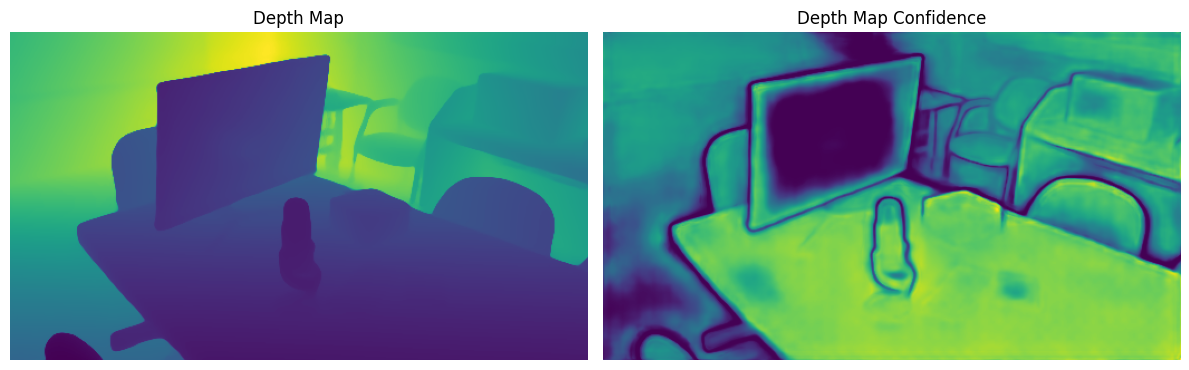

In [34]:
# @title Create a figure with the depth map and confidence of the first image provided to VGGT

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot depth map
axes[0].imshow(depth[0, 0].detach().cpu().numpy())
axes[0].set_title('Depth Map')
axes[0].axis('off')

# Plot depth confidence
axes[1].imshow(depth_conf[0, 0].detach().cpu().numpy())
axes[1].set_title('Depth Map Confidence')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [35]:
# @title Select points from within the first image to define scale, origin, and orientation of point cloud.
'''
This code allows you to define the real-world distance between two points.

You are also able to redefine the origin and orientation of the scene.
'''


def get_coords_from_pixel(current_world_points_tensor, x, y, img_index=0):
    return current_world_points_tensor[0, img_index, y, x, :]


def select_point(image):
    # Get the input image to display
    img_to_display = image.permute(1, 2, 0).cpu().numpy()
    img_to_display = (img_to_display * 255).astype(np.uint8)

    # Display the original image
    fig, ax = plt.subplots()
    ax.imshow(img_to_display)
    ax.set_title("Select a pixel in the image")
    plt.show()

    # Add a small pause to ensure the image is displayed before asking for input
    time.sleep(2)

    # Get user input for pixel coordinates
    try:
        x_coord = int(input("Enter the x-coordinate of the pixel: \n"))
        y_coord = int(input("Enter the y-coordinate of the pixel: \n"))
    except ValueError:
        print("Invalid input. Please enter integer values for coordinates.")
        exit()


    # Define the zoomed area to display the selected pixel (50x50 pixels)
    zoom_size = 50
    half_zoom = zoom_size // 2

    y_start = max(0, y_coord - half_zoom)
    y_end = min(img_to_display.shape[0], y_coord + half_zoom + 1)
    x_start = max(0, x_coord - half_zoom)
    x_end = min(img_to_display.shape[1], x_coord + half_zoom + 1)

    # Crop the image
    zoomed_img = img_to_display[y_start:y_end, x_start:x_end].copy()

    # Highlight the clicked pixel in the zoomed image.
    # The coordinates in the zoomed image are relative to the top-left corner of the zoomed area.
    highlight_y = y_coord - y_start
    highlight_x = x_coord - x_start

    zoomed_img[highlight_y, highlight_x] = [255, 0, 0]  # Set pixel to red (R, G, B)

    # Display the zoomed and highlighted image
    fig, ax = plt.subplots()
    ax.imshow(zoomed_img)
    ax.set_title(f"Pixel selected: ({x_coord}, {y_coord})")
    plt.show()

    con = input('Do you like this point selection? y/n \n').lower()

    clear_output(wait=True)

    if con == 'y':
        return x_coord, y_coord
    else:
        return select_point(image)


def align_point_cloud(world_points, images):

    # Get 2 points and their real distance for scale
    print('Select two points with known distance.')
    print('Selection of the first measured point:')
    sx1, sy1 = select_point(images[0])
    p1_coords = get_coords_from_pixel(world_points, sx1, sy1)

    print('Selection of the second measured point.')
    sx2, sy2 = select_point(images[0])
    p2_coords = get_coords_from_pixel(world_points, sx2, sy2)

    clear_output()
    time.sleep(1)

    real_d = input('What is the distance between these points? \n')

    # Normalize the distance between the points to 1, then multiply by the real world measurement.
    world_points = world_points / torch.norm(p1_coords - p2_coords)
    world_points = world_points * float(real_d)


    # Set the origin of the point cloud

    print('Select the desired origin point (0, 0, 0).')
    sox, soy = select_point(images[0])
    origin_coords = get_coords_from_pixel(world_points, sox, soy)
    print(f"Selected origin coordinates before translation: {origin_coords}") # Debug print added here
    # Translate the point cloud to the defined origin
    world_points = world_points - origin_coords
    verified_origin = get_coords_from_pixel(world_points, sox, soy)
    print(f"Verified origin after translation: {verified_origin}")

    time.sleep(1)



    # Get points for orienting the point cloud

    print('Selection of the positive x-axis.')
    sxpx, sxpy = select_point(images[0])
    px_axis = get_coords_from_pixel(world_points, sxpx, sxpy)
    initial_px_axis = px_axis.clone() # Store for later verification

    px_axis_n = px_axis / px_axis.norm()
    basis = torch.tensor([1.0, 0.0, 0.0], dtype=world_points.dtype).to(device)

    v = torch.cross(px_axis_n, basis)
    s = v.norm()
    c = torch.dot(px_axis_n, basis)

    if s < 1e-12:  # Avoiding edge-case numerical errors

        if c > 0.999999: # Point cloud is already aligned
            R = torch.eye(3, dtype=world_points.dtype)
        else: # Point cloud is opposite
            # rotate 180° around any perpendicular axis
            perp = torch.tensor([1, 0, 0], dtype=world_points.dtype).to(device)
            if torch.allclose(px_axis_n, perp):
                perp = torch.tensor([0, 1, 0], dtype=world_points.dtype).to(device)
            v = torch.cross(px_axis_n, perp)
            v = v / v.norm()

            # Rodrigues' formula for 180-degree rotation
            K = torch.tensor([[0, -v[2], v[1]],
                              [v[2], 0, -v[0]],
                              [-v[1], v[0], 0]], dtype=world_points.dtype).to(device)
            R = -torch.eye(3, dtype=world_points.dtype).to(device) + 2 * v[:, None] @ v[None, :]
    else:

        # Rodrigues' rotation formula
        K = torch.tensor([[0, -v[2], v[1]],
                          [v[2], 0, -v[0]],
                          [-v[1], v[0], 0]], dtype=world_points.dtype).to(device)
        R = torch.eye(3, dtype=world_points.dtype).to(device) + K + K @ K * ((1 - c) / (s**2))

    world_points = world_points @ R.T
    verified_x_axis_point = get_coords_from_pixel(world_points, sxpx, sxpy)
    print(f"Verified X-axis point after X-axis rotation: {verified_x_axis_point}")

    print('Selection of positive x-y plane:')
    xy_x, xy_y = select_point(images[0])
    p_xy = get_coords_from_pixel(world_points, xy_x, xy_y)

    y, z = p_xy[1], p_xy[2]
    theta = torch.atan2(-z, y)

    Rx = torch.tensor(
        [[1, 0, 0],
        [0, torch.cos(theta), -torch.sin(theta)],
        [0, torch.sin(theta),  torch.cos(theta)]]
    , dtype=world_points.dtype).to(device)

    world_points = world_points @ Rx.T
    verified_xy_plane_point = get_coords_from_pixel(world_points, xy_x, xy_y)
    print(f"Verified XY-plane point after XY-plane rotation: {verified_xy_plane_point}")
    print('Point cloud is aligned to the specified points. ')

    return world_points



world_points_aligned = align_point_cloud(world_points, images)

Point cloud is aligned to the specified points. 


In [44]:
import torch
import numpy as np
from plyfile import PlyData, PlyElement
import pandas as pd

def create_ply(world_points, indx, output_path):
    world_points_ = world_points[:, indx, :, :, :].flatten(0, -2).cpu().numpy()
    world_points_conf_ = world_points_conf[:, indx, :, :].flatten().cpu().numpy()

    img_np = np.stack([images[i].cpu().permute(1, 2, 0).numpy() for i in indx]) # [H, W, 4] if RGBA
    img_rgb = img_np[..., :3]# Take only the first 3 channels for cases where the images are RGBA

    # Normalize if needed
    if img_rgb.max() > 1.0:
        img_rgb = img_rgb / 255.0

    # Flatten to match world_points_
    colors = img_rgb.reshape(-1, 3)

    # Find points with a minimum confidence. Can be adjusted for each pointcloud if desires, or this setting essentially keeps all points.
    idx = np.where(world_points_conf_ > 0.01)[0]

    # Create DataFrame with points and colors
    df = pd.DataFrame({
        'x': world_points_[idx, 0],
        'y': world_points_[idx, 1],
        'z': -world_points_[idx, 2],
        'red': (colors[idx, 0] * 255).astype(np.uint8),
        'green': (colors[idx, 1] * 255).astype(np.uint8),
        'blue': (colors[idx, 2] * 255).astype(np.uint8),
    })

    # Convert to structured NumPy array
    vertex = np.array(
        list(zip(df['x'], df['y'], df['z'], df['red'], df['green'], df['blue'])),
        dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
              ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
    )

    # Create the PLY file
    el = PlyElement.describe(vertex, 'vertex')
    PlyData([el], text=False).write(output_path)



# Choose the name of the output file
output_path =  'point_cloud.ply'

#Choose which images to include into the point cloud
indx = [0]

create_ply(world_points_aligned, indx, output_path)

print(f"Point cloud saved to: {output_path}")
print('------------------workflow completed--------------------')

Point cloud saved to: point_cloud.ply
------------------workflow completed--------------------


In [45]:
# Directly download the .ply point cloud to view in external software. Meshlab works great, just turn off shading if you want the true colors.
from google.colab import files
files.download('point_cloud.ply')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>